In [1]:
import pandas as pd 
import numpy as np 
import statsmodels as st 
import sklearn 
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
train_df = pd.read_csv('../../data/feature/cb_train.csv')
val_df = pd.read_csv('../../data/feature/validation.csv')
test_df = pd.read_csv('../../data/data/test.csv')

In [3]:
train_df.head()
print(train_df.info())

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,...,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,...,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,...,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,...,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reservation-id          27499 non-null  int64 
 1   Gender                  27499 non-null  object
 2   Age                     27499 non-null  int64 
 3   Ethnicity               27499 non-null  object
 4   Educational_Level       27499 non-null  object
 5   Income                  27499 non-null  object
 6   Country_region          27499 non-null  object
 7   Hotel_Type              27499 non-null  object
 8   Expected_checkin        27499 non-null  object
 9   Expected_checkout       27499 non-null  object
 10  Booking_date            27499 non-null  object
 11  Adults                  27499 non-null  int64 
 12  Children                27499 non-null  int64 
 13  Babies                  27499 non-null  int64 
 14  Meal_Type               27499 non-null  object
 15  Vi

In [4]:
def cals_VIF(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]

    return vif

    

In [5]:
def pca_perc_var_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
    cumm_var_explained = np.cumsum(percent_var_explained)
    plt.plot(cumm_var_explained, 'bo-')
    plt.grid()
    plt.title("percentage of variation explained")
    plt.xlabel("n_components")
    plt.ylabel("% variance explained")
    plt.show()

def pca_scree_plot(df):
    df = df.copy()
    pca = PCA(n_components=df.shape[1])
    pca_data = pca.fit_transform(df)

    pcs = np.arange(pca.n_components_)+1
    plt.plot(pcs, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

In [6]:
def value_to_color(n_colors, palette, color_min, color_max,val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def hinton_plot(data, columns=[], corr_func='pearson'):
    if columns == []:
        corr = data.corr(method=corr_func)
    else:
        data = data.loc[:,columns]
        corr = data.corr(method=corr_func)

    corr = pd.melt(corr.reset_index(), id_vars='index')
    corr.columns = ['x','y','value']

    x = corr['x']
    y = corr['y']
    size = corr['value']

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1)
    ax = plt.subplot(plot_grid[:,:-1])

    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    size_scale = 500
    n_colors = 256
    palette = sns.diverging_palette(20, 220, n=n_colors) 
    color_min, color_max = [-1, 1]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size*size_scale,
        c=size.apply(lambda x: value_to_color(n_colors, palette, color_min, color_max, x)),
        marker='s'
    )

    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.set_title("hintonmap for multi-colinearity between features")

    ax = plt.subplot(plot_grid[:,-1])

    col_x = [0]*len(palette)
    bar_y = np.linspace(color_min, color_max, n_colors)
    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )

    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right()

In [7]:
def corr_wt_target(df, target, columns):
    absCorr = []
    for col in columns:
        absCorr.append(abs(df[target].corr(df[col])))

    ax = sns.lineplot(columns,absCorr)
    ax.set_xticklabels(df.columns,rotation=45, horizontalalignment='right')
    ax.set_title("Absolute correlation of features with the target")

ipykernel_launcher:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


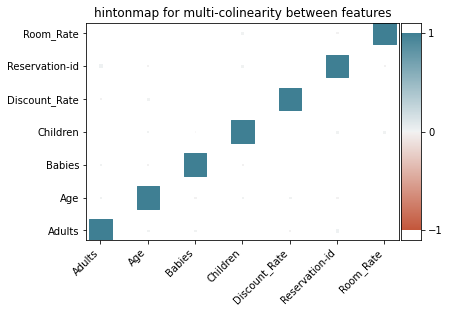

In [8]:
hinton_plot(train_df, train_df.columns.values)